People always ask: "can you randomize several times and use the proportion of selection, instead of
just one randomization"?

Let's try to figure this out.

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
nothere
nothere2
here
here2


/Users/jonathantaylor/git-repos/selection/selection/distributions/discrete_family.py:86: RuntimeWarning: divide by zero encountered in log
  self._lw = np.log(xw[:,1])


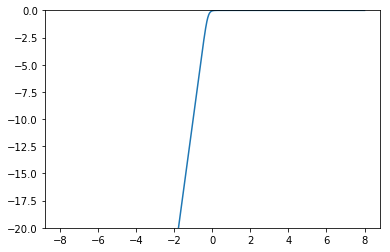

In [15]:
import numpy as np
import regreg.api as rr
import seaborn as sns
%matplotlib inline
%load_ext rpy2.ipython

%R library(splines)
import matplotlib.pyplot as plt
import scipy.stats
import statsmodels.api as sm

from selection.distributions.discrete_family import discrete_family

ntries, sigma, q = 21, 1, 0.3

def interval_event(Z, a=-np.inf, b=np.inf):
    return (Z > a) * (Z < b)

def algorithm(Z, ntries=ntries, q=q):
    
    proportion = 0
    for _ in range(ntries):
        proportion += (interval_event(Z + 0.5 * sigma * np.random.standard_normal(), 0, np.inf)) > 0

    proportion /= ntries
    return proportion > q

Z = np.linspace(-8, 8, 1001)
def fit_algorithm(algorithm, B=7000, ntries=ntries, q=q, Zval=Z, link='logit'):
    
    Z = np.random.standard_normal(B) * 2
    Z = np.hstack([Z, 
                   np.random.standard_normal(B), 
                   np.random.standard_normal(B) * 3, 
                   np.random.standard_normal(B) * 0.5])

    Y = np.array([algorithm(z, ntries=ntries, q=q) for z in Z])

    %R -i Y,Z,Zval 
    %R Z = as.numeric(Z*1)
    if link == 'probit':
        print('here')
        %R M2 = glm(Y ~ Z, family=binomial(link=probit))
    else:
        print('nothere')
        %R M2 = glm(Y ~ Z, family=binomial(link=logit))

    %R W = predict(M2, newdata=data.frame(Z=Zval), type='link')
    W = %R W
    if link == 'probit':
        print('here2')
        return scipy.stats.norm.cdf(W) 
    else:
        print('nothere2')
        return np.exp(W) / (1 + np.exp(W))

def simulate(ntries=ntries, sigma=sigma, truth=0):
               
    while True:
        Z = np.random.standard_normal() + truth
        if algorithm(Z, ntries, q=q):
            return Z

Z = np.linspace(-8, 8, 1001)
W1 = fit_algorithm(algorithm, ntries=ntries, q=q, Zval=Z, link='logit')
W2 = fit_algorithm(algorithm, ntries=ntries, q=q, Zval=Z, link='probit')
plt.plot(Z, np.log(W1))
plt.gca().set_ylim([-20, 0])
selective_law1 = discrete_family(Z, W1 * scipy.stats.norm.pdf(Z))
selective_law2 = discrete_family(Z, W2 * scipy.stats.norm.pdf(Z))

def pivot1(z, truth=0):
    return 1 - selective_law1.cdf(truth, z)

def pivot2(z, truth=0):
    return 1 - selective_law2.cdf(truth, z)


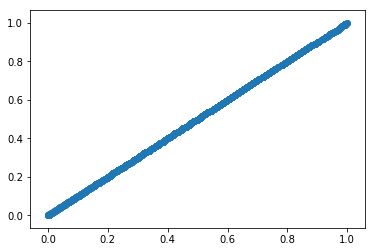

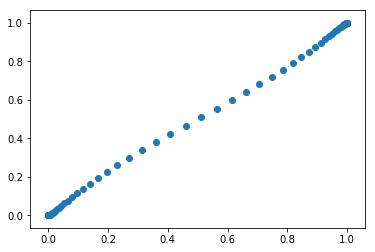

In [17]:
P0 = []

for _ in range(1000):
    Zobs = simulate()
    P0.append((pivot1(Zobs),
              1 - scipy.stats.norm.cdf(simulate()),
              pivot2(Zobs)))
P0 = np.array(P0)
U = np.linspace(0, 1, 101)
plt.figure()
plt.scatter(P0[:,0], P0[:,2])
plt.figure()
plt.scatter(W1, W2)
